In [62]:
from Helpers import *

def get_Gravity_Matrix(x,xhat,g,ghat,alpha):
    """
    return the gravity matrices terms
    """
    Ms = 52
    Ls = 1.57
    m1 = Ms*0.028
    m2 = Ms*0.022
    l1 = Ls*0.186
    l2 = Ls*(0.146)
    lc1 = l1*0.436
    lc2 = l2*0.682
 
    G = np.array([g*(m1*lc1*np.cos(x[0]+alpha)+m2*(lc2*np.cos(x[0]+alpha+x[3])+l1*np.cos(x[0]+alpha))),
                    g*m2*lc2*np.cos(x[0]+x[3]+alpha)])
    Ghat = np.array([ghat*(m1*lc1*np.cos(xhat[0]+alpha)+m2*(lc2*np.cos(xhat[0]+alpha+xhat[3])+l1*np.cos(xhat[0]+alpha))),
                    ghat*m2*lc2*np.cos(xhat[0]+alpha+xhat[3])])
    Ghatdot = np.array([ghat*(-m1*lc1*np.sin(xhat[0]+alpha)*xhat[1]+m2*(-lc2*np.sin(xhat[0]+alpha+xhat[3])*(xhat[1]+xhat[4])-l1*np.sin(xhat[0]+alpha)*xhat[1])),
                    -ghat*m2*lc2*np.sin(xhat[0]+alpha+xhat[3])*(xhat[1]+xhat[4])])
    return G,Ghat,Ghatdot

In [61]:
def M1(ts,Ms = 50,Ls = 1.6):
    m1 = Ms*0.028
    m2 = Ms*0.022
    l1 = Ls*0.186
    l2 = Ls*(0.146)
    lc1 = l1*0.436
    lc2 = l2*0.682
    I1 = m1*(l1*0.322)**2
    I2 = m2*(l2*0.468)**2
    return np.array([[m1*lc1*lc1+I1+m2*lc2*lc2+I2+m2*(l1*l1+2*l1*lc2*cos(ts)),
                      m2*lc2*lc2+I2+m2*l1*lc2*cos(ts)],
                      [m2*lc2*lc2+I2+m2*l1*lc2*cos(ts),
                       m2*lc2*lc2+I2]])
def M2(ts):
    return np.array([[a1+2*a2*cos(ts),a3+a2*cos(ts)],
              [a3+a2*cos(ts),a3]])

def FindBestParam(Angle = 0,i = 0,j=0):
    emin = 1400
    m = 0
    l = 0
    for M in np.linspace(55,85,401):
        for Ls in np.linspace(1.5,1.9,401):
                if abs((M1(Angle,M,Ls)-M2(Angle))[i,j]) < emin:
                    emin = abs((M1(0,M,Ls)-M2(0))[i,j])
                    m = M
                    l = Ls
    print(m,l)

def FindBestParamG(Angle = 0):
    emin = 1400
    m = 0
    l = 0
    for M in np.linspace(50,60,401):
        for Ls in np.linspace(1.5,1.7,401):
                if np.sum((M1(Angle,M,Ls)-M2(Angle))**2) < emin:
                    emin = np.sum((M1(Angle,M,Ls)-M2(Angle))**2)
                    m = M
                    l = Ls
    print(m,l)
for angle in [0,pi/4,pi/2]:
    FindBestParam(angle,0,0)

    FindBestParam(angle,0,1)

    FindBestParam(angle,1,1)

    FindBestParamG(angle)
    print("\n")


55.0 1.514
55.0 1.524
60.55 1.522
51.875 1.562


85.0 1.9
85.0 1.9
60.55 1.522
51.3 1.578


85.0 1.9
85.0 1.9
60.55 1.522
53.65 1.57




In [63]:
def Feedback_Linearization_with_Gravity(Duration = .6,w1 = 1e8,w2 = 1e8,w3 = 1e4,w4 = 1e4,r1 = 1e-5,r2 = 1e-5,targets = [0,55],starting_point = [0,30],plot = True,alpha = 1,Activate_Noise = False,Side = "Left",newtonfunc = newtonf,newtondfunc = newtondf,Num_iter = 300, ShowJ = False, ShowEstimate = False,Delay = .06,FF = False,FFonset = 0):
    
    """
    Duration (float) : Duration of the movement

    w1 (float) : Weight associated to the penalty on shoulder angle 
    
    w2 (float) : Weight associated to the penalty on elbow angle 

    w3 (float) : Weight associated to the penalty on shoulder angular velocity

    w4 (float) : Weight associated to the penalty on elbow angular velocity

    r1 (float) : Weight associated to the motor cost on shoulder torques

    r2 (float) : Weight associated to the motor cost on elbow torques

    targets (array of float of size 2): X,Y Position of the end point of the movement
        must be a biomechanically feasible end point considering that the shoulder is at (0,0)

    starting_point (array of float of size 2): X,Y Position of the starting point of the movement
        must be a biomechanically feasible starting point considering that the shoulder is at (0,0)
    
    plot (boolean) : Allowing plot outputs of the hand trajectory for the experiment

    Noise_Variance (float) : Gaussian variance associated to the white noises in the model

    Side (String) : Side of the force field ("Left" or "Right")
    
    newtonfunc([thetas,thetae],X,Y) : Function that computes the difference between the change of variable from the angular to cartesian system, and the targetted X,Y position
                                      It's a tool for the newton method to compute the desired joint angles that generate a precise X,Y position of the hand

    newtondfunc([thetas,thetae],X,Y) : Derivative of newtonfunc

    Num_iter (int) : Number of simulations steps

    ShowJ (boolean) : Computes and print the total cost function generated by the controller at the end of the movement
    """

    dt = Duration/Num_iter 
    kdelay = int(Delay/dt)

    obj1,obj2 = newton(newtonfunc,newtondfunc,1e-8,1000,targets[0],targets[1]) #Defini les targets
    st1,st2 = newton(newtonfunc,newtondfunc,1e-8,1000,starting_point[0],starting_point[1])

    x0 = np.array([st1,0,0,st2,0,0,obj1,obj2])
    x0_with_delay = np.tile(x0, kdelay + 1) 

    Num_Var = 8
    
    #Define Weight Matrices of the cost function
    R = np.array([[r1,0],[0,r2]])
    Q = np.array([[w1,0,0,0,0,0,-w1,0],[0,w3,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],
               [0,0,0,w2,0,0,0,-w2],[0,0,0,0,w4,0,0,0],[0,0,0,0,0,0,0,0],
               [0-w1,0,0,0,0,0,w1,0],[0,0,0,-w2,0,0,0,w2]])

    
    
    #Define the Dynamic of the linear system 

    Kfactor = 1/0.06

    A_basic = np.array([[1,dt,0,0,0,0,0,0],[0,1,dt,0,0,0,0,0],[0,0,1,0,0,0,0,0],[0,0,0,1,dt,0,0,0],[0,0,0,0,1,dt,0,0],[0,0,0,0,0,1,0,0],[0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,1]])
    B_basic = np.array([[0,0],[0,0],[dt,0],[0,0],[0,0],[0,dt],[0,0],[0,0]])
    sigma = np.zeros((Num_Var*(kdelay+1),Num_Var*(kdelay+1)))

    #Incorporation of delay 

    H = np.zeros((Num_Var,(kdelay+1)*Num_Var))
    H[:,(kdelay)*Num_Var:]= np.identity(Num_Var)

    A = np.zeros(((kdelay+1)*Num_Var,(kdelay+1)*Num_Var))
    A[:Num_Var,:Num_Var] = A_basic
    A[Num_Var:,:-Num_Var] = np.identity((kdelay)*Num_Var)
    B = np.zeros(((kdelay+1)*Num_Var,2))
    B[:Num_Var] = B_basic

    #Compute the Feedback Gain of the Control law
    S = Q

    array_L = np.zeros((Num_iter-1,2,Num_Var))   
    array_S = np.zeros((Num_iter,Num_Var,Num_Var)) 
    array_S[-1] = S
    for k in range(Num_iter-1):
        L = np.linalg.inv(R+B_basic.T@S@B_basic)@B_basic.T@S@A_basic
        array_L[Num_iter-2-k] = L
        S = A_basic.T@S@(A_basic-B_basic@L)
        array_S[Num_iter-2-k] = S
        
    #Initialize matrices 
    L = array_L


    #Initialize the arrays to stock the simulations 
    array_zhat = np.zeros((Num_iter,Num_Var))
    array_x = np.zeros((Num_iter,Num_Var-2)) 
    array_z = np.zeros((Num_iter,Num_Var)) 
    y = np.zeros((Num_iter-1,Num_Var))

    #Initialize the state vectors of the linear system
    array_zhat[0] = x0.flatten()
    array_z[0] = x0.flatten()
    zhat = np.copy(x0_with_delay)
    z =  np.copy(x0_with_delay)

    #Initialize the state vectors of the nonlinear system
    x = np.zeros(Num_Var-2)
    x[0],x[1] = x0[0],x0[3]
    new_x = np.copy(x)

    #Incorporation of delay 

    #Perform the task
    J = 0
    acc = np.zeros(2)
    for k in range(Num_iter-1):
        #Compute the matrices of the FL technique in function of the current estimate state 
        
        if (np.sin(x[0]+x[1])*33+np.sin(x[0])*30 > FFonset) and (FF == True):

            F = Compute_f_new_version(x[0:2],x[2:4],acc,.3)
            if Side == "Left": F*=-1

        else : 
            F = [0,0]

        _,_,Omega_measure,measure_noise = Compute_Noise(Num_Var,alpha,B)
        
        G,Ghat,Ghatdot = get_Gravity_Matrix(z,zhat,9.81,9.81,0)
        C = np.array([-zhat[4]*(2*zhat[1]+zhat[4])*a2*np.sin(zhat[3]),zhat[1]*zhat[1]*a2*np.sin(zhat[3])])

        M = np.array([[a1+2*a2*cos(zhat[3]),a3+a2*cos(zhat[3])],[a3+a2*cos(zhat[3]),a3]])

        Cdot = np.array([-a2*zhat[5]*(2*zhat[1]+zhat[4])*sin(zhat[3])-a2*zhat[4]*(2*zhat[2]+zhat[5])*sin(zhat[3])
                         -a2*zhat[4]*zhat[4]*(2*zhat[1]+zhat[4])*cos(zhat[3]),2*zhat[1]*zhat[2]*a2*sin(zhat[3])+zhat[1]*zhat[1]*a2*cos(zhat[3])*zhat[4]])

        Mdot = np.array([[-2*a2*sin(zhat[3])*zhat[4],-a2*sin(zhat[3])*zhat[4]],[-a2*sin(zhat[3])*zhat[4],0]])
        O = Cov_Matrix(M,Kfactor,Num_Var)
        Omega_sens = np.zeros((Num_Var*(kdelay+1),Num_Var*(kdelay+1)))
        Omega_sens[:Num_Var,:Num_Var] = O
        # Compute the command through the FL technique
        
        v = -L[k].reshape(np.flip(B_basic.shape))@zhat[:Num_Var]
        u = 1/Kfactor*M@(v)+1/Kfactor*Mdot@(np.array([zhat[2],zhat[5]]))+M@(np.array([zhat[2],zhat[5]]))+C+Ghat+Bdyn@np.array([zhat[1],zhat[4]])+1/Kfactor*(Cdot+Ghatdot)+1/Kfactor*Bdyn@np.array([zhat[2],zhat[5]])
        if ShowJ : J+= u.T@R@u
        # Delayed Observation of the Nonlinear system expressed in linear coordinates
        
        y[k] = (H@z).flatten()
        if Activate_Noise : y[k]+=measure_noise
        
        # Kalman Filter Gains 

        K = A@sigma@H.T@np.linalg.inv(H@sigma@H.T+Omega_measure)
        sigma = Omega_sens + (A - K@H)@sigma@A.T

        # Compute the Estimation of the system in the linear system
        
        zhat = A@zhat + B@v + K@(y[k]-H@zhat)
        
        # Simulate the nonlinear plant 
        
        C = np.array([-x[3]*(2*x[2]+x[3])*a2*np.sin(x[1]),x[2]*x[2]*a2*np.sin(x[1])])
        
        M = np.array([[a1+2*a2*cos(x[1]),a3+a2*cos(x[1])],[a3+a2*cos(x[1]),a3]])

        
        Cdot = np.array([-a2*acc[1]*(2*x[2]+x[3])*sin(x[1])-a2*x[3]*(2*acc[0]+acc[1])*sin(x[1])
                         -a2*x[3]*x[3]*(2*x[2]+x[3])*cos(x[1]),2*x[2]*acc[0]*a2*sin(x[1])+x[2]*x[2]*a2*cos(x[1])*x[3]])

        Mdot = np.array([[-2*a2*sin(x[1])*x[3],-a2*sin(x[1])*x[3]],[-a2*sin(x[1])*x[3],0]])
        
        #print(np.linalg.solve(M,(x[4:6]-Bdyn@(x[2:4])-C))-acc)
        new_x[0:2] += dt*x[2:4]
        new_x[2:4] += dt*(np.linalg.solve(M,(x[4:6]-Bdyn@(x[2:4])-C-G))+F)
        new_x[4:6] += dt*Kfactor*(u-x[4:6])
        if Activate_Noise : 
            #new_x[4:6]+=np.ones(2)*motor_noise[2]
            new_x[4:6]+=np.random.normal(0,1e-3,2)
        
        z = np.concatenate((np.array([new_x[0],new_x[2],acc[0],new_x[1],new_x[3],acc[1],z[6],z[7]]),z[:-Num_Var]))
        
        
        # Transform the new nonlinear state into the coordinates of the linear system
        C = np.array([-z[4]*(2*z[1]+z[4])*a2*np.sin(z[3]),z[1]*z[1]*a2*np.sin(z[3])])

        M = np.array([[a1+2*a2*cos(z[3]),a3+a2*cos(z[3])],[a3+a2*cos(z[3]),a3]])

        acc = np.linalg.solve(M,(new_x[4:6]-Bdyn@(new_x[2:4])-C-G))+F
        #Stock the true and estimated states

        array_z[k+1] = z[:Num_Var].flatten()
        array_zhat[k+1] = zhat[:Num_Var].flatten()
        array_x[k+1] = new_x[:Num_Var-2].flatten()
        
        x = np.copy(new_x)
        

    if ShowJ : 
        #J+= z.T@Q@z
        #print("Total cost of FL: "+str(J)[:7])
        pass

    #Change of coordinates from angular to cartesian 
    

    X = np.cos(array_z[:,0]+array_z[:,3])*33+np.cos(array_z[:,0])*30
    Y = np.sin(array_z[:,0]+array_z[:,3])*33+np.sin(array_z[:,0])*30

    if ShowEstimate:
        X2 = np.cos(array_zhat[:,0]+array_zhat[:,3])*33+np.cos(array_zhat[:,0])*30
        Y2 = np.sin(array_zhat[:,0]+array_zhat[:,3])*33+np.sin(array_zhat[:,0])*30

    #Plotting
    color1 = plt.get_cmap('RdPu')(kdelay*10 / Num_iter)

    if plot : 
        
        plt.grid(linestyle='--')
        #if FF : 
            #plt.plot(np.linspace(-10,10,100),np.ones(100)*FFonset,linestyle = "--",alpha = .7,color = "grey")
        plt.axis("equal")
        color = "cyan"
        ls = "-"
        lw = 3
        if Side == "Right": 
            ls = "--"
            lw = 1
            color = "red"
        if FF == False:
            ls = "-"
            lw = 1
            color = "grey"
        if Delay > 0 : 
            if FF ==False : plt.plot(X,Y,color = color,label = "FL("+str(int(kdelay*dt*1000))+ " ms delay)",linewidth = lw,linestyle = ls)
            if FF == True : plt.plot(X,Y,color = color,label = "FL("+str(int(kdelay*dt*1000))+ " ms delay)\n "+ str(Side)+" FF",linewidth = lw,linestyle = ls)
        else : plt.plot(X,Y,color = "#48494B",label = "Feedback Linearization",linewidth = 1)
        if ShowEstimate: 
            plt.plot(X2,Y2,color ="black",label = "Estimation",linewidth = 1,linestyle = "--",alpha = .8)
        plt.xlabel("X [cm]")
        plt.ylabel("Y [cm]")
        plt.scatter([starting_point[0],targets[0]],[starting_point[1],targets[1]],color = "orange",marker = "s" , s = 600, alpha= .3)
    if ShowJ : return X,Y,J,array_x
    return X,Y

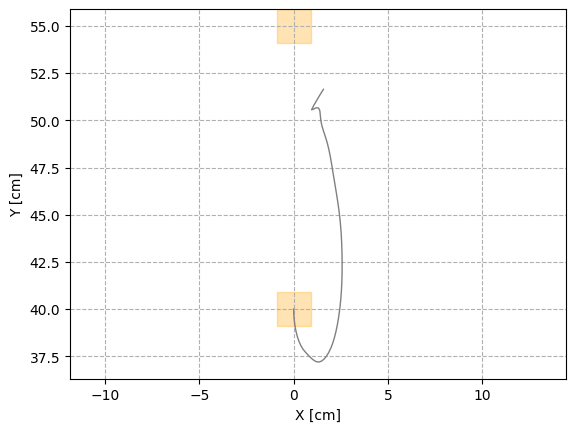

In [78]:
X,Y = Feedback_Linearization_with_Gravity(Duration=.6,w1 = 1e7,w2 = 1e7,w3 = 1e4,w4 = 1e4,r1 = 1e-5,r2 = 1e-5,targets = [0,55],starting_point = [0,40],Num_iter = 60)